In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from __future__ import division
from deltasigma import *
import warnings
warnings.filterwarnings('ignore')

In [3]:
fig_number = 0
base_name = 'dsdemo_idletones'
def save_fig(fig_number):
    save_name = f'{base_name}_fig{fig_number:02d}.pdf'
    fig_number = fig_number + 1
    plt.gcf().savefig(save_name)
    return fig_number

# Idle Tones in $n$th-order SDM
Hanspeter Schmid FHNW/ISE, December 2025

Some definitions: in this example, we are using a 128-kHz sampling frequency, with a maximum frequency band of 4 kHz.  Therefore, 

In [4]:
osr = 128/4

Then we have an $n$th-order SDM without zeros,

In [5]:
opt    = 0
order  = [1, 2, 3]
Hinf   = [2., 4., 2.]
Ns     = 3
f0     = 0.

## Synthesize the NTF

In [6]:
ntf = [ synthesizeNTF(o, osr, opt, h, f0)  for (o, h) in zip(order, Hinf) ]
_   = [ print(pretty_lti(n)) for n in ntf ]

 (z - 1) 
---------
    z    
 (z - 1)^2 
-----------
    z^2    
              (z - 1)^3              
-------------------------------------
 (z^2 - 1.16z + 0.4896) (z - 0.5098) 


## Simulate some values including a sensor's $kT/C$ noise

In [7]:
N  = 2**16;
fs = 128e3;
C  = 25e-12;
k  = 1.38e-23;
T  = 300;
noisePower = k*T/C;
# fB = np.ceil(N/(2*osr));
ftest = 370;
t = np.arange(N)/fs;
na = 4;                      # spectrum averaging factor
fbin = fs/N*na
fbin

7.8125

In [8]:
binIdle = 12

In [9]:
fIdle = binIdle*fbin
fIdle

93.75

In [10]:
uDC = fIdle/fs
uDC

0.000732421875

Very small offset from centre

In [11]:
# uDC = 0.000666666666666666

In [12]:
Atest = 1e-9;
# Atest = 0.05;
u = Atest*np.sin(2*np.pi*ftest*t) + np.sqrt(noisePower)*np.random.randn(1,N) + uDC;
v = []
xn = []
xmax = []
y = []
for k in range(Ns):
    print(k)
    [v_, xn_, xmax_, y_] = simulateDSM(u, ntf[k]);
    v.append(v_)
    xn.append(xn_)
    xmax.append(xmax_)
    y.append(y_)

0
1
2


## Plot simulated spectrum as well as ideal NTF

In [13]:
from scipy.signal import welch
import scipy as sp

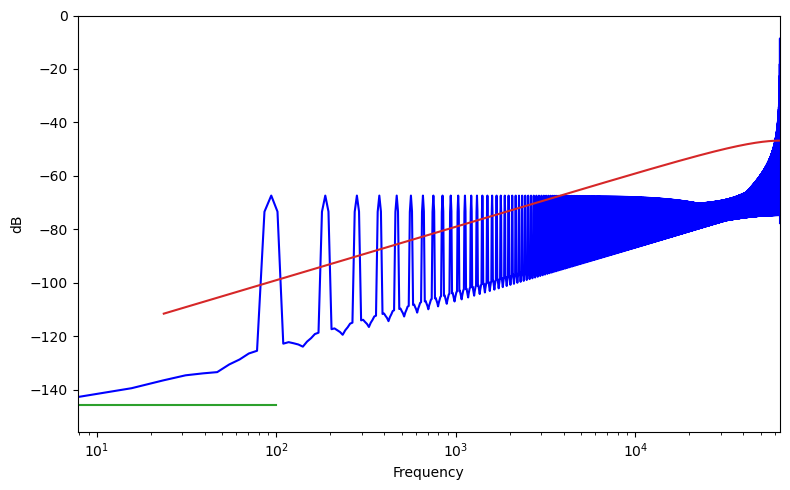

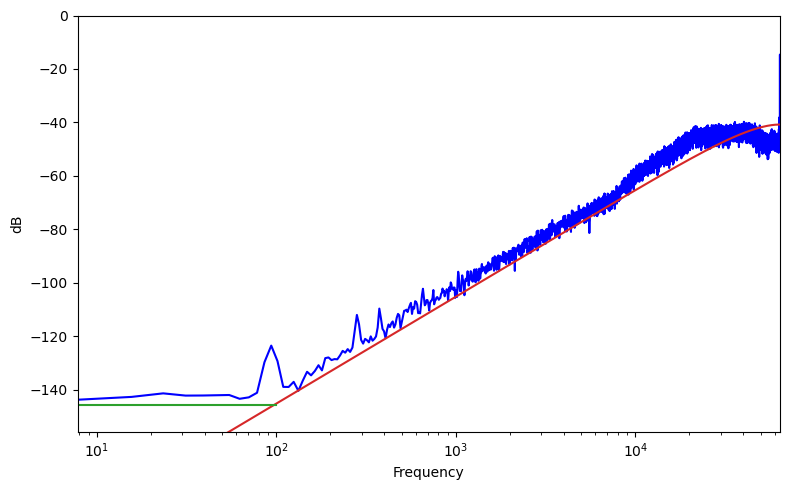

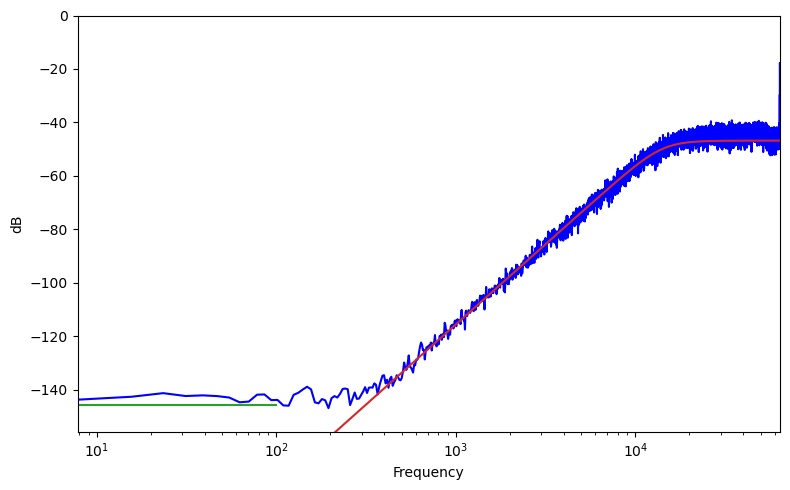

In [14]:
for k in range(Ns):
    fig, ax1 = plt.subplots(figsize=(8, 5))
    nx = np.size(v[k])
    w = sp.signal.windows.hann(int(np.floor(nx/na)))
    CG = np.mean(w)
    NG = np.mean(w**2)
    [fxx, Pxx] = welch(v[k], window=w, fs=fs)

    ax1.semilogx(fxx, dbv(np.sqrt(2*Pxx)), 'b')

    f = np.append(np.linspace(0, 0.75/osr, 128), np.linspace(0.75/osr, 0.5, 128))*fs
    z = np.exp(2j*np.pi*f/fs)
    Vlsb = 2
    qnoisePSD = Vlsb**2/12/(fs/2)
    magH = dbv(evalTF(ntf[k], z)*np.sqrt(qnoisePSD))
    magC = dbv(np.sqrt(noisePower/(fs/2)))

    ax1.semilogx(f, magH, color='tab:red')
    ax1.semilogx([1, 100],[magC, magC], color='tab:green')

    ax1.set_xlabel('Frequency')
    ax1.set_ylabel('dB')
    ax1.set_xlim(fxx[1], fs/2)
    _ = ax1.set_ylim(magC-10, 0)
    fig.tight_layout()
    fig_number = save_fig(fig_number)

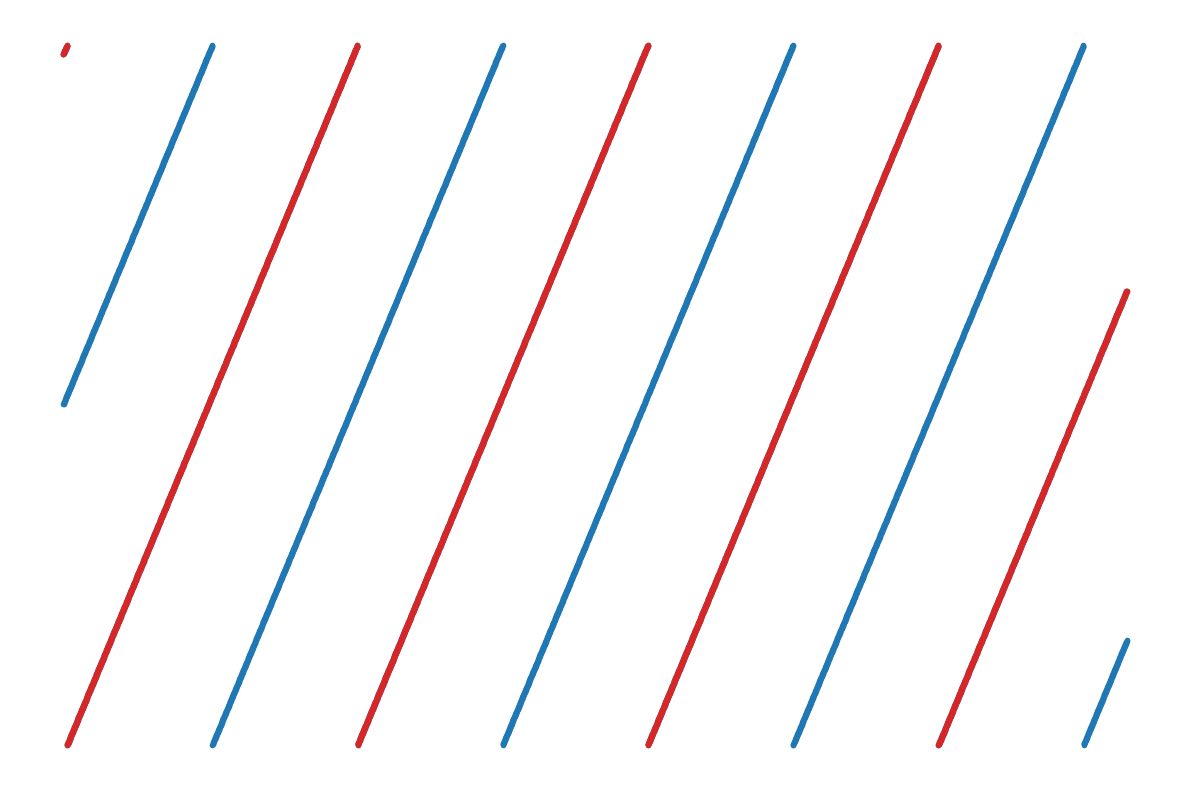

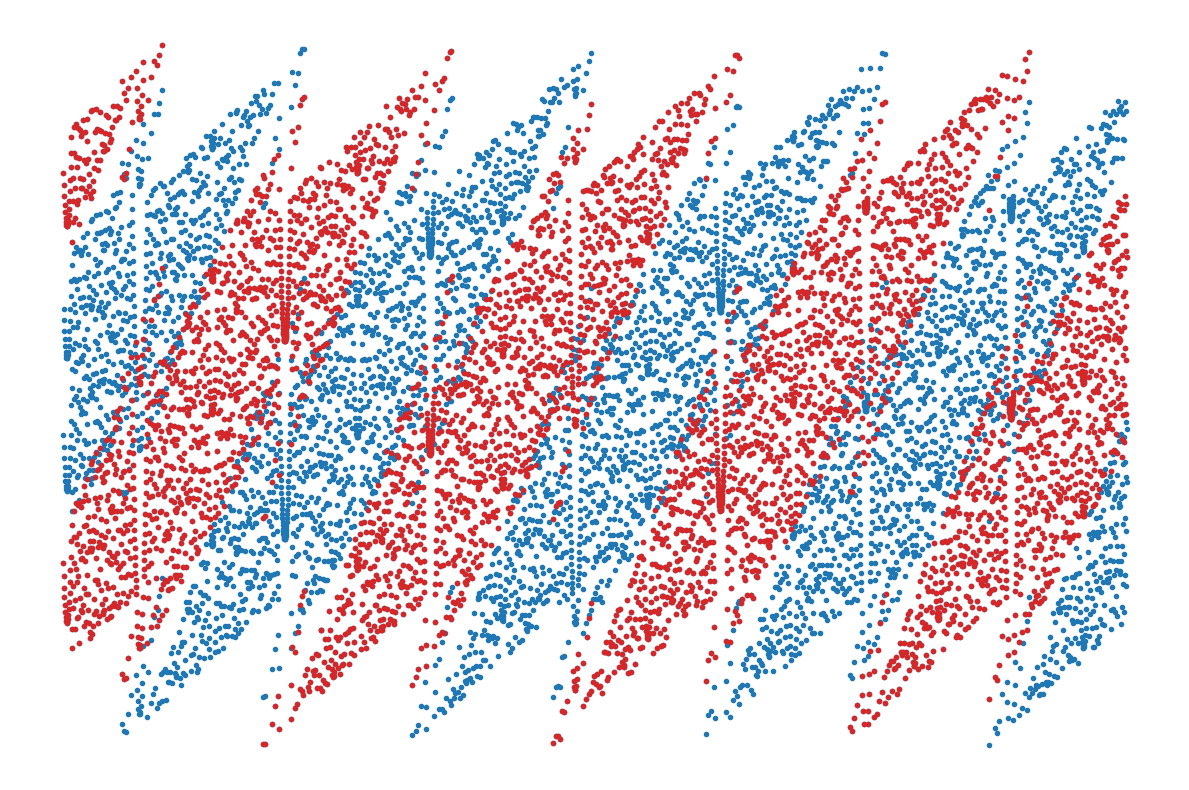

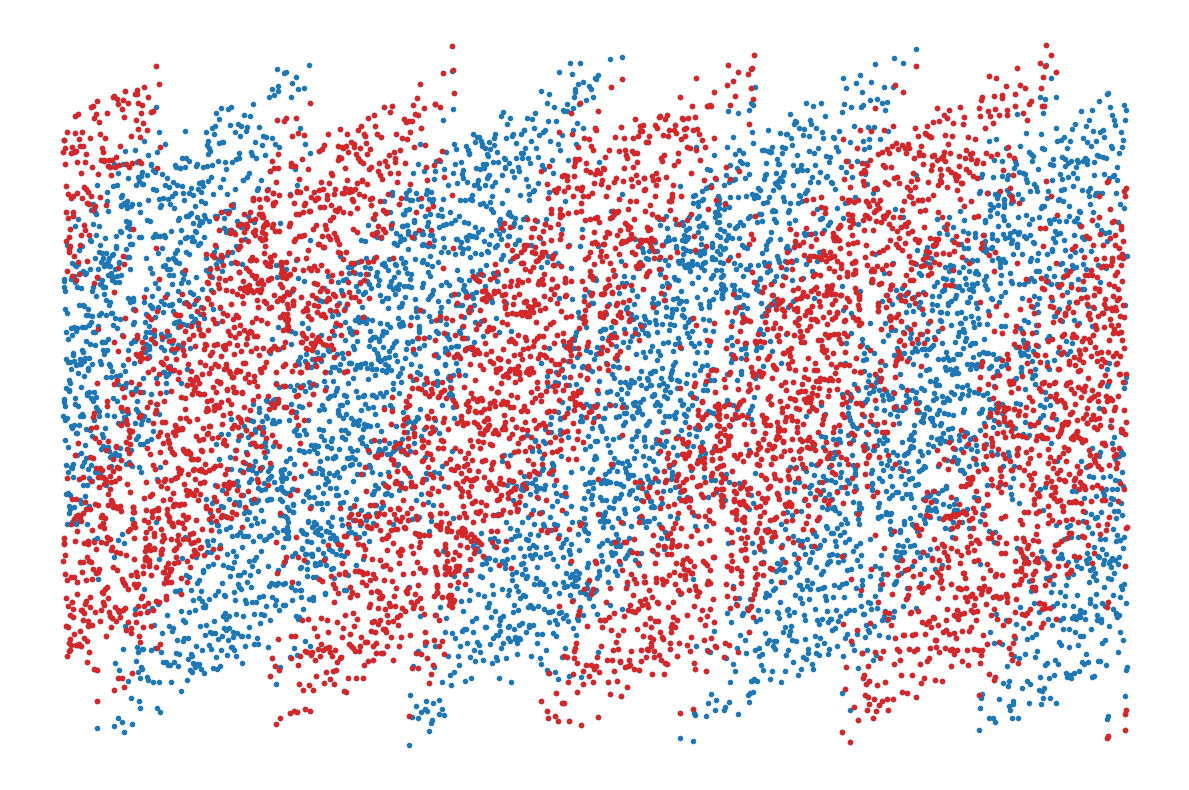

In [15]:
for k in range(Ns):
    start=42284;
    length=10000;
    fig, ax1 = plt.subplots(figsize=(12, 8))
    ax1.plot(t[start:start+length], y[k][start:start+length], '.', color='tab:blue')
    ax1.plot(t[start:start+length:2], y[k][start:start+length:2], '.', color='tab:red')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Quantizer input')
    ax1.axis('off')
    fig.tight_layout()
    fig_number = save_fig(fig_number)

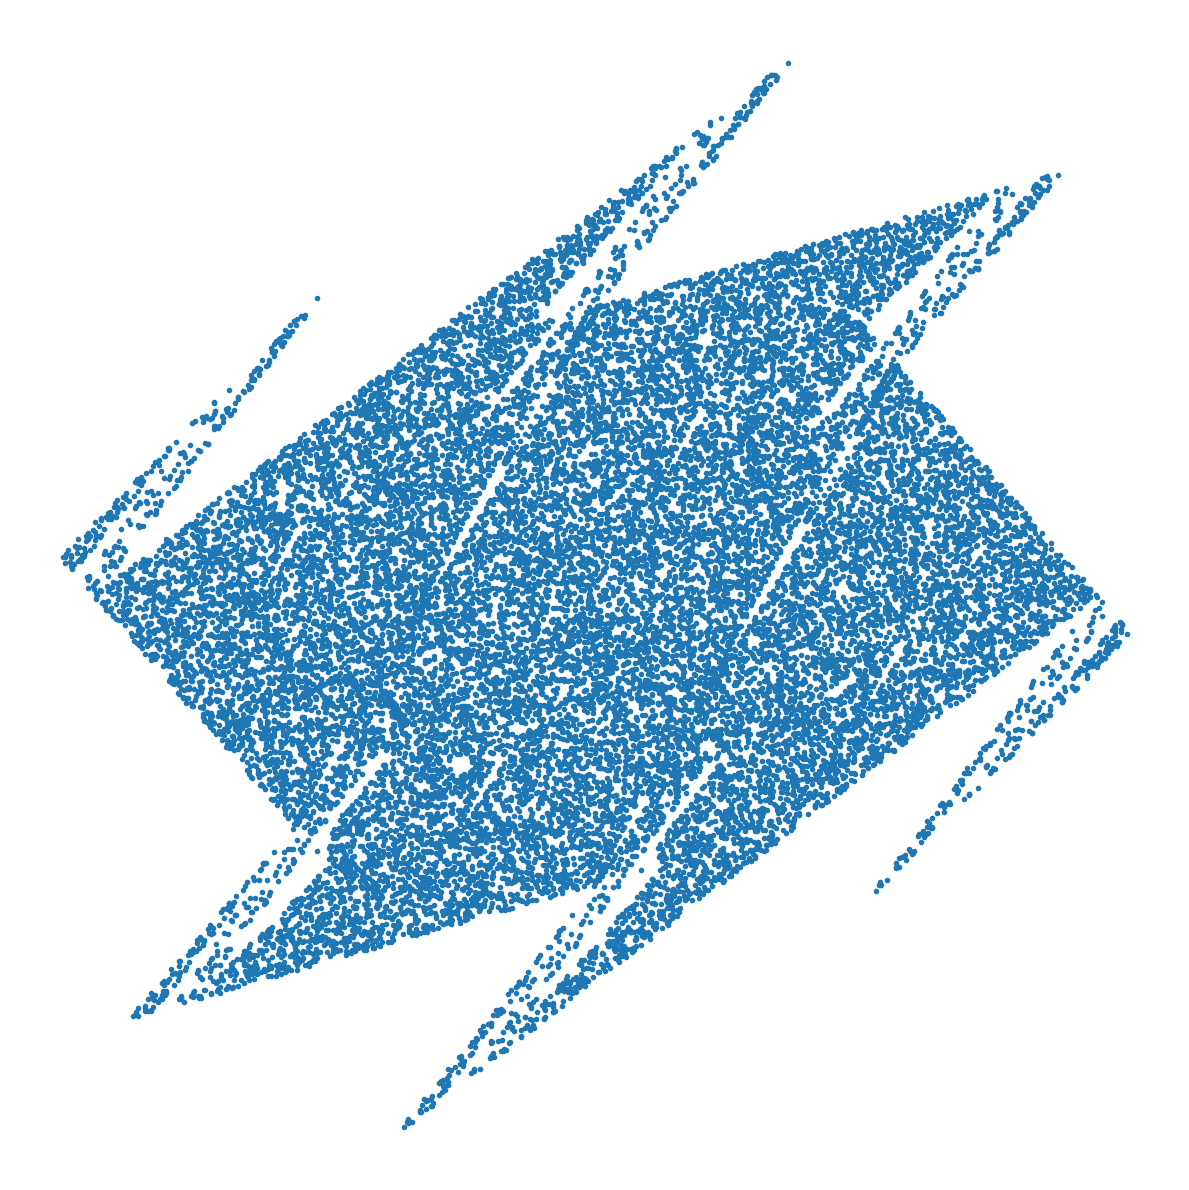

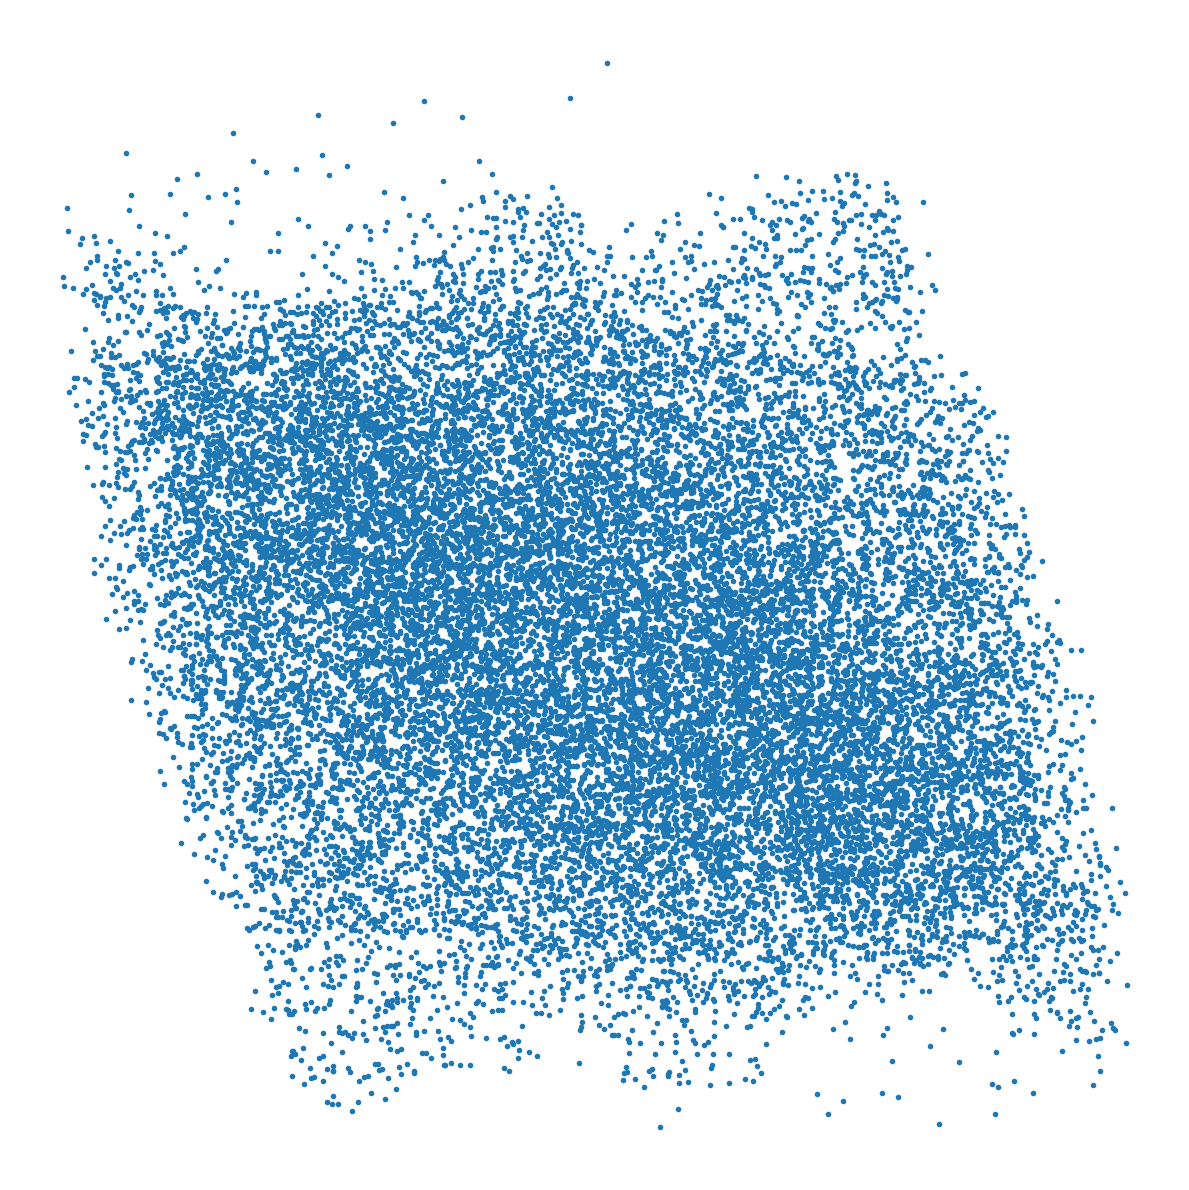

In [16]:
for k in range(Ns):
    if order[k] > 1:
        fig, ax1 = plt.subplots(figsize=(12, 12))
        ax1.plot(xn[k][0, start:start+24000], xn[k][1, start:start+24000], '.', color='tab:blue')
        ax1.axis('off')
        fig.tight_layout()
        fig_number = save_fig(fig_number)